In [1]:
# The argument --n_days set the number of days
# Whitout argument --n_days is simulated just one day
#%run main_home_simulator 3house_base.txt 

# Example: For 2 days
%run main_home_simulator 3houses_base.txt --n_days 6

Processing: 99.9%


In [2]:
import nilmtk.dataset_converters as conv

In [3]:
#set the location to save the .h5 file
#Change the location for the folder in your computer
location="C:\\Users\\Hader\\Desktop\\Codigos\\programas_nilmtk\\Low_Voltage_Network_Simulator_v1_Python\\"

name='lvns_3houses.h5'
folder_ground_truth=location+'ground_truth\\'
conv.convert_lvns(results_of_LVNS,location+name,file_groundtruth=folder_ground_truth)

Loading house 1... 1 2 3 4 5 6 7 8  
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting alva to HDF5!


In [4]:
from nilmtk import DataSet

dataset=DataSet(location+name)

In [5]:
#check the number of houses
dataset.buildings

OrderedDict([(1, Building(instance=1, dataset='LVNS')),
             (2, Building(instance=2, dataset='LVNS')),
             (3, Building(instance=3, dataset='LVNS'))])

In [6]:
# just to plot figures
%matplotlib inline 

import matplotlib

plt= matplotlib.pyplot

matplotlib.rcParams['figure.figsize'] = (13,6)
matplotlib.pyplot.style.use('ggplot') 
matplotlib.rc('font',**{'family' : 'normal','weight' : 'normal', 'size'   : 16})

Loading data for meter ElecMeterID(instance=4, building=1, dataset='LVNS')     
Done loading data all meters for this chunk.


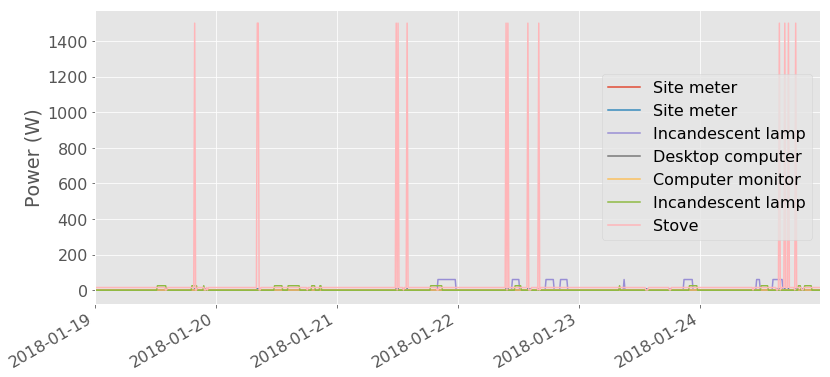

In [7]:
dataset.buildings[1].elec.plot()

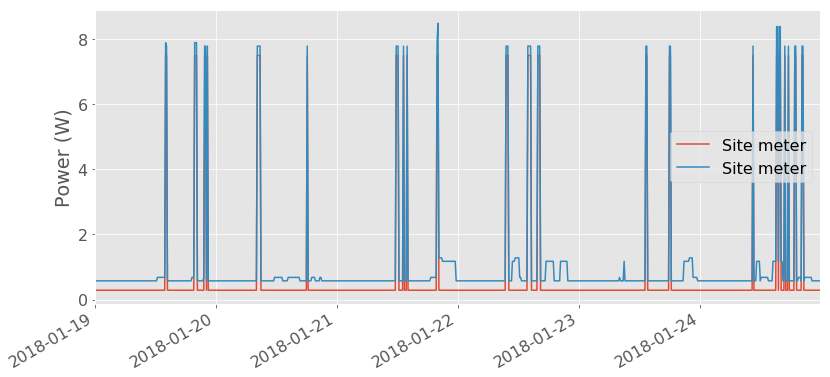

In [8]:
#main meters
dataset.buildings[1].elec.mains().plot()

Loading data for meter ElecMeterID(instance=4, building=1, dataset='LVNS')     
Done loading data all meters for this chunk.


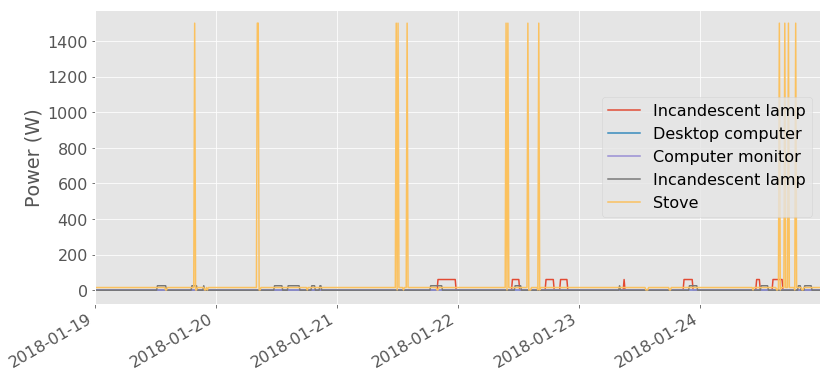

In [9]:
#submeters
dataset.buildings[1].elec.submeters().plot()

In [1]:
#Disaggregatin algorithms

from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM

from sklearn.metrics import mean_squared_error
from nilmtk import MeterGroup


In [2]:
#Load the dataset two times to set window and use half as train and half as test
#set window is made in function nilm_tests
train = DataSet(location+name)
test = DataSet(location+name)

In [3]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        new_chunk=one_variable(chunk)
        chunk_drop_na = new_chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = meter.load(sample_period=sample_period).next()
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    #gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

def one_variable(chunk):
    
    a=chunk.copy()
    
    for col in a.columns:
        if not col==('power', 'active'):
            del a[col]
    
    return a

def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)

def nilm_tests(classifiers,train,test,sample_period,window_day,building):
    
    train.set_window(end=window_day)
    test.set_window(start=window_day)

    train_elec = train.buildings[building].elec
    test_elec = test.buildings[building].elec
    
    predictions = {}
    for clf_name, clf in classifiers.iteritems():
        print("*"*20)
        print(clf_name)
        print("*" *20)
        clf.train(train_elec, sample_period=sample_period)
        gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

    rmse = {}
    for clf_name in classifiers.keys():
        rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
    rmse = pd.DataFrame(rmse)
    
    return rmse

In [ ]:
window_day="22-1-2018" # is the day to split data set in this case dataset begun in 18-1-2018 and finish in 24-1-2018
classifiers = {'CO':CombinatorialOptimisation(),'FHMM':FHMM()}
sample_period=10 # FHMM and CO takes to much time to sample_period under 10 seconds

rmse_all={} # dictionary for results

In [ ]:
building=1
rmse_all[building]=nilm_tests(classifiers,train,test,sample_period,window_day,building)

********************
FHMM
********************


C:\Users\Hader\Anaconda\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=6)
  data = data.resample(**resample_kwargs)


Training model for submeter 'ElecMeter(instance=5, building=1, dataset='LVNS', appliances=[Appliance(type='incandescent lamp', instance=2)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='LVNS', appliances=[Appliance(type='desktop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='LVNS', appliances=[Appliance(type='computer monitor', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='LVNS', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Loading data for meter ElecMeterID(instance=3, building=1, dataset='LVNS')     

C:\Users\Hader\Anaconda\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:336: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  return resampled.index[0]


Loading data for meter ElecMeterID(instance=4, building=1, dataset='LVNS')     
Done loading data all meters for this chunk.
Training model for submeter 'MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='LVNS', appliances=[Appliance(type='stove', instance=1)])
  ElecMeter(instance=4, building=1, dataset='LVNS', appliances=[Appliance(type='stove', instance=1)])
)'
Loading data for meter ElecMeterID(instance=2, building=1, dataset='LVNS')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='LVNS')     
Done loading data all meters for this chunk.
********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='LVNS', appliances=[Appliance(type='incandescent lamp', instance=2)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='LVNS', appliances=[Appliance(type='desktop computer', instance=1)])'
Training model for submeter 'ElecMeter(ins

In [ ]:
building=2
rmse_all[building]=nilm_tests(classifiers,train,test,sample_period,window_day,building)

********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='LVNS', appliances=[Appliance(type='incandescent lamp', instance=3)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='LVNS', appliances=[Appliance(type='desktop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='LVNS', appliances=[Appliance(type='computer monitor', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='LVNS', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=2, dataset='LVNS', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='LVNS', appliances=[Appliance(type='incandescent lamp', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='LVNS', appliances=[Appliance(type='elect

In [ ]:
building=3
rmse_all[building]=nilm_tests(classifiers,train,test,sample_period,window_day,building)

C:\Users\Hader\Anaconda\envs\nilmtk-env\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


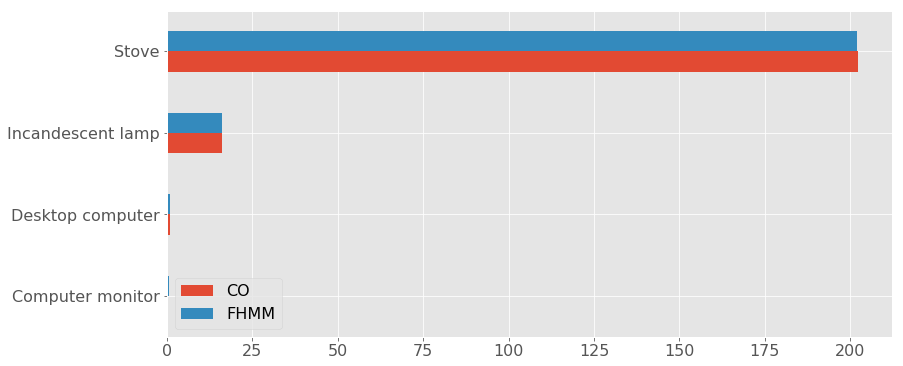

In [14]:
rmse_all[1].plot(kind="barh")

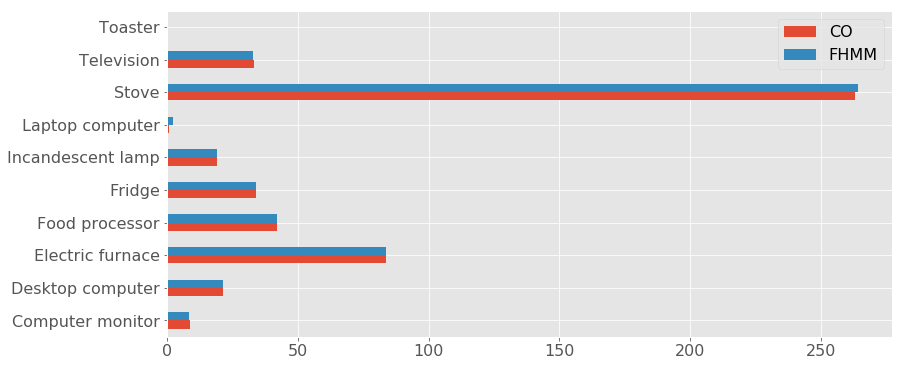

In [15]:
rmse_all[2].plot(kind="barh")

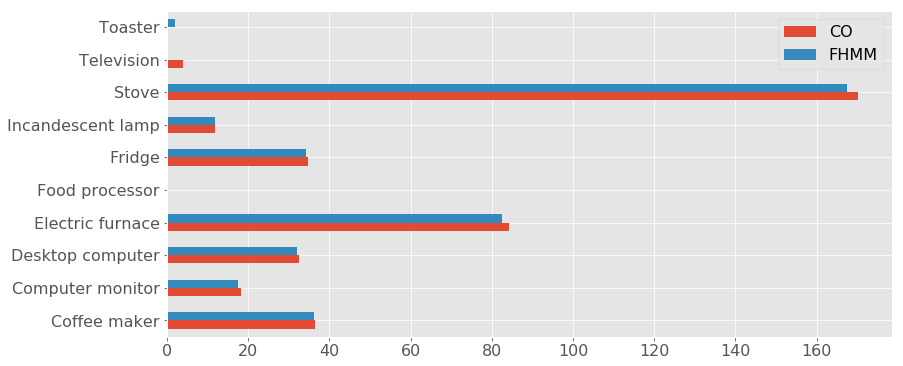

In [16]:
rmse_all[3].plot(kind="barh")